# 07 - REDUCCIÓN DE DIMENSIÓN

En este notebook se evalúan diferentes técnicas de reducción de dimensionalidad y se establece si es posible reducir la complejidad del modelo final.

**Mejores modelos identificados:**
1. Regresión Logística (Balanced Accuracy Test = 0.9556)
2. Red Neuronal (Balanced Accuracy Test = 0.9302)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

import umap
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:
# Cargar los conjuntos de datos preprocesados
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'Número de features: {X_train.shape[1]}')

X_train: (16000, 13)
X_test: (4000, 13)
Número de features: 13


## Balanceo de Clases con SMOTE


In [7]:
print("Distribución en Train antes de SMOTE:")
print(y_train.value_counts())

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar resample solo al conjunto de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribución en Train después de SMOTE:")
print(y_train_balanced.value_counts())

# Reemplazar las variables de entrenamiento
X_train = X_train_balanced
y_train = y_train_balanced

Distribución en Train antes de SMOTE:
isFraud
0    15840
1      160
Name: count, dtype: int64

Distribución en Train después de SMOTE:
isFraud
0    15840
1    15840
Name: count, dtype: int64


## Análisis Individual de Variables

Se realiza un análisis individual de cada una de las características, utilizando medidas de correlación y/o índice de discriminación que refleje la capacidad discriminativa de las variables.


CORRELACIÓN DE CARACTERÍSTICAS CON LA VARIABLE OBJETIVO
amount              0.551581
type_TRANSFER       0.477468
step                0.325647
type_CASH_OUT       0.153008
oldbalanceOrg       0.091708
nameOrig_encoded   -0.008863
type_DEBIT         -0.051253
newbalanceDest     -0.081463
newbalanceOrig     -0.173735
oldbalanceDest     -0.194284
nameDest_encoded   -0.327202
type_CASH_IN       -0.352988
type_PAYMENT       -0.451932
Name: isFraud, dtype: float64


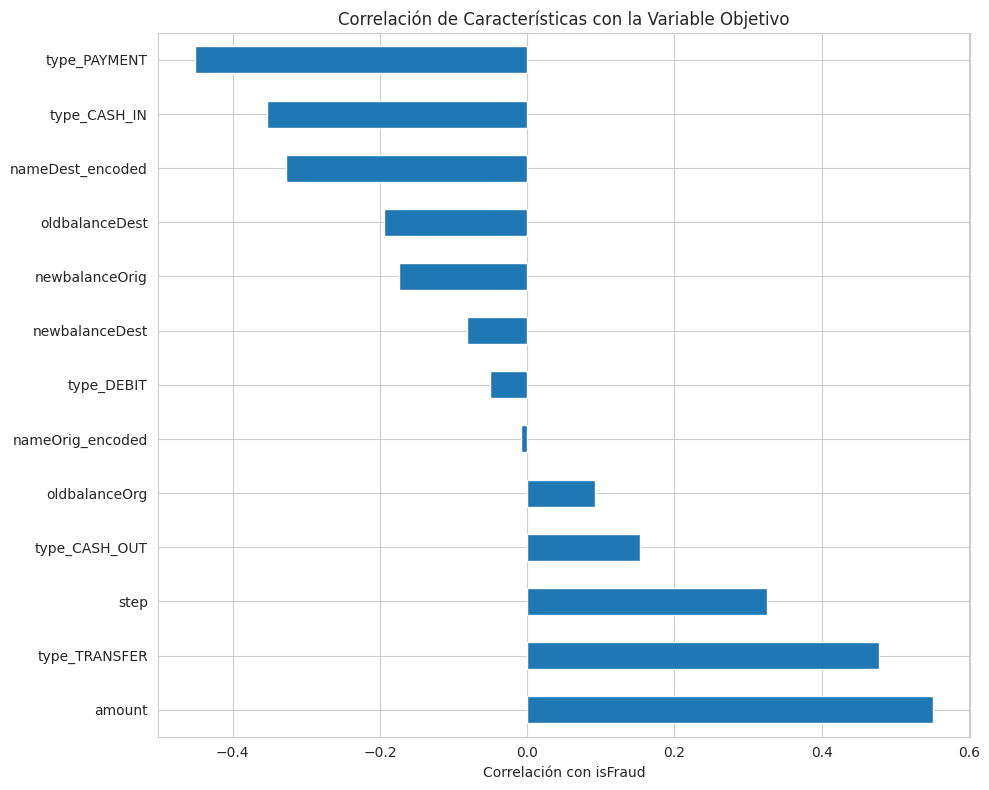

In [11]:
# Combinar datos para análisis de correlación
data_combined = X_train.copy()
data_combined['isFraud'] = y_train.values

# Calcular correlaciones con la variable objetivo
correlations = data_combined.corr()['isFraud'].drop('isFraud').sort_values(ascending=False)

print("\nCORRELACIÓN DE CARACTERÍSTICAS CON LA VARIABLE OBJETIVO")
print(correlations)

# Visualizar correlaciones
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh')
plt.xlabel('Correlación con isFraud')
plt.title('Correlación de Características con la Variable Objetivo')
plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [26]:
### Identificación de Características Candidatas a Eliminación

# Definir umbral para características débiles
weak_features_corr = correlations[abs(correlations) < 0.052].index.tolist()

print("\nCARACTERÍSTICAS CANDIDATAS A SER ELIMINADAS")
print(f"Características con |Correlación| < 0.05: {weak_features_corr}")

if len(weak_features_corr) == 0:
    print("\nNo se encontraron características con muy baja correlación.")
    print("Todas las características muestran cierta relación con la variable objetivo.")
else:
    print(f"\nCaracterísticas candidatas a eliminación: {weak_features_corr}")



CARACTERÍSTICAS CANDIDATAS A SER ELIMINADAS
Características con |Correlación| < 0.05: ['nameOrig_encoded', 'type_DEBIT']

Características candidatas a eliminación: ['nameOrig_encoded', 'type_DEBIT']


## Extracción de Características Lineal (PCA)

Se utiliza PCA para encontrar un conjunto de componentes principales con un tamaño inferior al número de variables original.

**Criterio de Selección:** Se seleccionará el número de componentes que explique al menos el 95% de la varianza total, garantizando que se preserve la mayor parte de la información mientras se reduce la dimensionalidad.

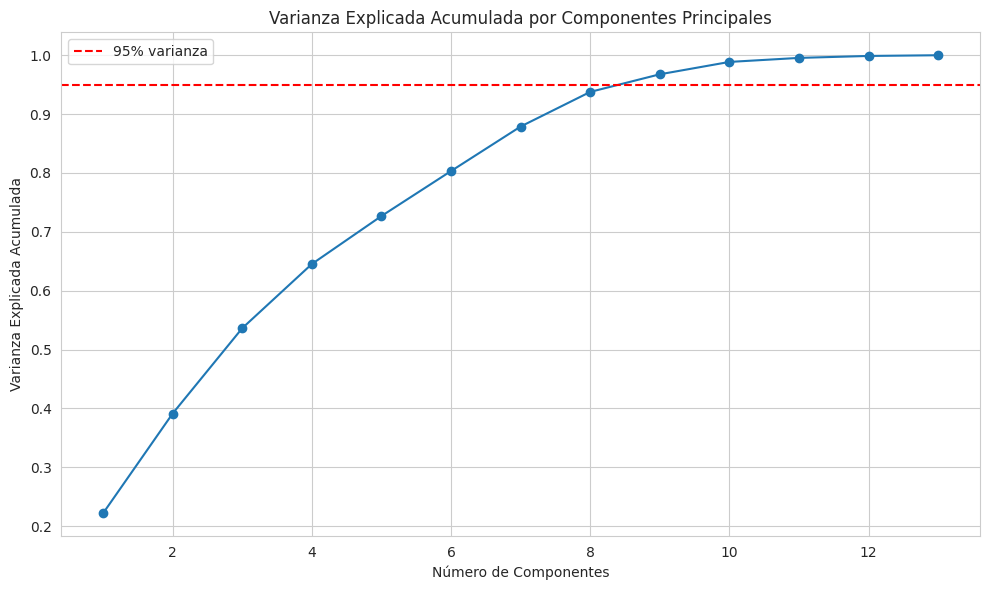


Número de componentes para 95% de varianza: 9
Varianza explicada con 9 componentes: 0.9676
Reducción de dimensionalidad: 13 → 9 (30.8% reducción)


In [16]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA con todos los componentes
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calcular varianza explicada acumulada
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Visualizar
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Determinar número de componentes para 95% de varianza
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNúmero de componentes para 95% de varianza: {n_components_95}")
print(f"Varianza explicada con {n_components_95} componentes: {cumulative_variance[n_components_95-1]:.4f}")
print(f"Reducción de dimensionalidad: {X_train.shape[1]} → {n_components_95} ({(1 - n_components_95/X_train.shape[1])*100:.1f}% reducción)")

In [17]:
# Aplicar PCA con el número de componentes seleccionado
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Forma de datos originales: {X_train.shape}")
print(f"Forma de datos con PCA: {X_train_pca.shape}")

Forma de datos originales: (31680, 13)
Forma de datos con PCA: (31680, 9)


### Función para Evaluar Modelos

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Entrena el modelo y calcula todas las métricas
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    metrics = {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_test, y_proba),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
    }

    return metrics

### Evaluación de Modelos con PCA

In [19]:
# Modelo 1: Regresión Logística con PCA
print("\n REGRESIÓN LOGÍSTICA CON PCA")
lr_pca = LogisticRegression(
    C=10,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

metrics_lr_pca = evaluate_model(lr_pca, X_train_pca, X_test_pca, y_train, y_test, 'Regresión Logística + PCA')

print(f"\nBalanced Accuracy en Test: {metrics_lr_pca['Balanced Accuracy']:.4f}")
print(f"Accuracy: {metrics_lr_pca['Accuracy']:.4f}")
print(f"AUC-ROC: {metrics_lr_pca['AUC-ROC']:.4f}")


 REGRESIÓN LOGÍSTICA CON PCA

Balanced Accuracy en Test: 0.8963
Accuracy: 0.9173
AUC-ROC: 0.9642


In [22]:
# Modelo 2: Red Neuronal con PCA
print("\nRED NEURONAL CON PCA")
nn_pca = MLPClassifier(
    activation='relu',
    solver='sgd',
    learning_rate_init=0.1,
    learning_rate='adaptive',
    alpha=0.001,
    batch_size=50,
    hidden_layer_sizes=(10,),
    random_state=1,
    n_iter_no_change=500,
    max_iter=1000
)

metrics_nn_pca = evaluate_model(nn_pca, X_train_pca, X_test_pca, y_train, y_test, 'Red Neuronal + PCA')

print(f"\nBalanced Accuracy en Test: {metrics_nn_pca['Balanced Accuracy']:.4f}")
print(f"Accuracy: {metrics_nn_pca['Accuracy']:.4f}")
print(f"AUC-ROC: {metrics_nn_pca['AUC-ROC']:.4f}")


RED NEURONAL CON PCA

Balanced Accuracy en Test: 0.8899
Accuracy: 0.9780
AUC-ROC: 0.9813


### Tabla de Resultados PCA

In [23]:
# Tabla comparativa PCA
results_pca_table = pd.DataFrame([
    {
        'Modelo': 'Regresión Logística (Original)',
        'Dimensionalidad': X_train.shape[1],
        'Reducción (%)': '0.0',
        'Balanced Accuracy': 0.9556,
        'Accuracy': 0.9610,
        'AUC-ROC': 0.9843,
        'F1-Score': 0.9734
    },
    {
        'Modelo': 'Regresión Logística + PCA',
        'Dimensionalidad': n_components_95,
        'Reducción (%)': f"{(1 - n_components_95/X_train.shape[1])*100:.1f}",
        'Balanced Accuracy': metrics_lr_pca['Balanced Accuracy'],
        'Accuracy': metrics_lr_pca['Accuracy'],
        'AUC-ROC': metrics_lr_pca['AUC-ROC'],
        'F1-Score': metrics_lr_pca['F1-Score']
    },
    {
        'Modelo': 'Red Neuronal (Original)',
        'Dimensionalidad': X_train.shape[1],
        'Reducción (%)': '0.0',
        'Balanced Accuracy': 0.9302,
        'Accuracy': 0.9842,
        'AUC-ROC': 0.9654,
        'F1-Score': 0.9873
    },
    {
        'Modelo': 'Red Neuronal + PCA',
        'Dimensionalidad': n_components_95,
        'Reducción (%)': f"{(1 - n_components_95/X_train.shape[1])*100:.1f}",
        'Balanced Accuracy': metrics_nn_pca['Balanced Accuracy'],
        'Accuracy': metrics_nn_pca['Accuracy'],
        'AUC-ROC': metrics_nn_pca['AUC-ROC'],
        'F1-Score': metrics_nn_pca['F1-Score']
    }
])

print("\n" + "="*120)
print("TABLA DE RESULTADOS: PCA")
print("="*120)
print(results_pca_table.to_string(index=False))
print("="*120)


TABLA DE RESULTADOS: PCA
                        Modelo  Dimensionalidad Reducción (%)  Balanced Accuracy  Accuracy  AUC-ROC  F1-Score
Regresión Logística (Original)               13           0.0           0.955600   0.96100 0.984300  0.973400
     Regresión Logística + PCA                9          30.8           0.896338   0.91725 0.964223  0.174564
       Red Neuronal (Original)               13           0.0           0.930200   0.98420 0.965400  0.987300
            Red Neuronal + PCA                9          30.8           0.889899   0.97800 0.981345  0.421053


## Extracción de Características No Lineal (UMAP)

Se utiliza UMAP para encontrar un conjunto de componentes con un tamaño inferior al número de variables original.

**Criterio de Selección:** Se probará con diferentes números de componentes, seleccionando aquel que mantenga el mejor balance entre reducción dimensional y rendimiento del modelo.

In [25]:
# Probar diferentes números de componentes UMAP
n_components_to_test = [n_components_95, max(n_components_95-2, 3), max(n_components_95-4, 2)]

best_score_umap = -1
best_n_components_umap = n_components_95
best_X_train_umap = None
best_X_test_umap = None

print("\n BÚSQUEDA DEL NÚMERO ÓPTIMO DE COMPONENTES UMAP")
for n_comp in n_components_to_test:
    reducer = umap.UMAP(n_components=n_comp, random_state=42)
    X_train_umap_temp = reducer.fit_transform(X_train_scaled)
    X_test_umap_temp = reducer.transform(X_test_scaled)

    # Evaluar con Regresión Logística (más rápida)
    lr_temp = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
    lr_temp.fit(X_train_umap_temp, y_train)
    y_pred_temp = lr_temp.predict(X_test_umap_temp)
    ba_temp = balanced_accuracy_score(y_test, y_pred_temp)

    print(f"\nComponentes UMAP: {n_comp}")
    print(f"Balanced Accuracy (Regresión Logística): {ba_temp:.4f}")

    if ba_temp > best_score_umap:
        best_score_umap = ba_temp
        best_n_components_umap = n_comp
        best_X_train_umap = X_train_umap_temp
        best_X_test_umap = X_test_umap_temp

print(f"\n\nMejor configuración UMAP: {best_n_components_umap} componentes")


 BÚSQUEDA DEL NÚMERO ÓPTIMO DE COMPONENTES UMAP

Componentes UMAP: 9
Balanced Accuracy (Regresión Logística): 0.7139

Componentes UMAP: 7
Balanced Accuracy (Regresión Logística): 0.7572

Componentes UMAP: 5
Balanced Accuracy (Regresión Logística): 0.7064


Mejor configuración UMAP: 7 componentes


In [27]:
# Usar el mejor UMAP encontrado
X_train_umap = best_X_train_umap
X_test_umap = best_X_test_umap
n_components_umap = best_n_components_umap

print(f"\nForma de datos originales: {X_train.shape}")
print(f"Forma de datos con UMAP: {X_train_umap.shape}")


Forma de datos originales: (31680, 13)
Forma de datos con UMAP: (31680, 7)


### Evaluación de Modelos con UMAP

In [30]:
# Modelo 1: Regresión Logística con UMAP
print("\nREGRESIÓN LOGÍSTICA CON UMAP")
lr_umap = LogisticRegression(
    C=10,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

metrics_lr_umap = evaluate_model(lr_umap, X_train_umap, X_test_umap, y_train, y_test, 'Regresión Logística + UMAP')

print(f"\nBalanced Accuracy en Test: {metrics_lr_umap['Balanced Accuracy']:.4f}")
print(f"Accuracy: {metrics_lr_umap['Accuracy']:.4f}")
print(f"AUC-ROC: {metrics_lr_umap['AUC-ROC']:.4f}")


REGRESIÓN LOGÍSTICA CON UMAP

Balanced Accuracy en Test: 0.7572
Accuracy: 0.8868
AUC-ROC: 0.7682


In [31]:
# Modelo 2: Red Neuronal con UMAP
print("\nRED NEURONAL CON UMAP")
nn_umap = MLPClassifier(
    activation='relu',
    solver='sgd',
    learning_rate_init=0.1,
    learning_rate='adaptive',
    alpha=0.001,
    batch_size=50,
    hidden_layer_sizes=(10,),
    random_state=1,
    n_iter_no_change=500,
    max_iter=1000
)

metrics_nn_umap = evaluate_model(nn_umap, X_train_umap, X_test_umap, y_train, y_test, 'Red Neuronal + UMAP')

print(f"\nBalanced Accuracy en Test: {metrics_nn_umap['Balanced Accuracy']:.4f}")
print(f"Accuracy: {metrics_nn_umap['Accuracy']:.4f}")
print(f"AUC-ROC: {metrics_nn_umap['AUC-ROC']:.4f}")


RED NEURONAL CON UMAP

Balanced Accuracy en Test: 0.8384
Accuracy: 0.8760
AUC-ROC: 0.9213


### Tabla de Resultados UMAP

In [32]:
# Tabla comparativa UMAP
results_umap_table = pd.DataFrame([
    {
        'Modelo': 'Regresión Logística (Original)',
        'Dimensionalidad': X_train.shape[1],
        'Reducción (%)': '0.0',
        'Balanced Accuracy': 0.9556,
        'Accuracy': 0.9610,
        'AUC-ROC': 0.9843,
        'F1-Score': 0.9734
    },
    {
        'Modelo': 'Regresión Logística + UMAP',
        'Dimensionalidad': n_components_umap,
        'Reducción (%)': f"{(1 - n_components_umap/X_train.shape[1])*100:.1f}",
        'Balanced Accuracy': metrics_lr_umap['Balanced Accuracy'],
        'Accuracy': metrics_lr_umap['Accuracy'],
        'AUC-ROC': metrics_lr_umap['AUC-ROC'],
        'F1-Score': metrics_lr_umap['F1-Score']
    },
    {
        'Modelo': 'Red Neuronal (Original)',
        'Dimensionalidad': X_train.shape[1],
        'Reducción (%)': '0.0',
        'Balanced Accuracy': 0.9302,
        'Accuracy': 0.9842,
        'AUC-ROC': 0.9654,
        'F1-Score': 0.9873
    },
    {
        'Modelo': 'Red Neuronal + UMAP',
        'Dimensionalidad': n_components_umap,
        'Reducción (%)': f"{(1 - n_components_umap/X_train.shape[1])*100:.1f}",
        'Balanced Accuracy': metrics_nn_umap['Balanced Accuracy'],
        'Accuracy': metrics_nn_umap['Accuracy'],
        'AUC-ROC': metrics_nn_umap['AUC-ROC'],
        'F1-Score': metrics_nn_umap['F1-Score']
    }
])

print("\n" + "="*120)
print("TABLA DE RESULTADOS: UMAP")
print("="*120)
print(results_umap_table.to_string(index=False))
print("="*120)


TABLA DE RESULTADOS: UMAP
                        Modelo  Dimensionalidad Reducción (%)  Balanced Accuracy  Accuracy  AUC-ROC  F1-Score
Regresión Logística (Original)               13           0.0           0.955600   0.96100 0.984300  0.973400
    Regresión Logística + UMAP                7          46.2           0.757197   0.88675 0.768169  0.099404
       Red Neuronal (Original)               13           0.0           0.930200   0.98420 0.965400  0.987300
           Red Neuronal + UMAP                7          46.2           0.838384   0.87600 0.921313  0.114286
